# Webscraping and analyzing reviews on comics for readcomiconline.to

In [48]:
# GENERAL
import re
import json
import numpy as np
import pandas as pd

# WEBSCRAPING
import requests
import bs4 as bs

# SELENIUM
from selenium import webdriver
from selenium.webdriver.support.wait import WebDriverWait

# NLP
import spacy
from textblob import TextBlob
from collections import Counter
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# GRAPHICS
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [49]:
# LOAD NLP MODEL
# nlp = spacy.load('en_core_web_lg')

# 0. Webscrape results, export to dataframe

## 0.0 Functions

In [50]:
def harvest(urls, df=None, outfile="comic_comments/comic_comments.csv"):
    """
    Takes a list of urls of comic series and a df (optional)
    Scrapes and runs NLP for every comic series url in the list.
    Scrapes comments, populates tables and exports CSVs for every issue in the series.
    Returns df of all comics/comments
    """
    # INITIATE DF IF NOT PASSED IN
    if df is None:
        df = pd.DataFrame(columns=['Webpage','Message', 'Author', 'Likes', 'Dislikes', 'NumReports'])
        print("new df created")

    else:
        print(f"df loaded. df length: {len(df)}")

    # INSTANTATES SELENIUM WEBDRIVER
    driver = webdriver.Opera(executable_path='webdriver/operadriver_mac64/operadriver')

    # CALLS SCRAPE_SERIES FOR EACH SERIES, UPDATES df
    for series_homepage in urls:
        print(f"Attempting to scrape {series_homepage}")
        df = scrape_series(series_homepage=series_homepage, driver=driver, outfile=outfile, df=df)
        
    driver.quit()
    return df

In [51]:
# SCRAPE COMIC SERIES URL - GET ALL ISSUES URL
def get_issues(series_homepage, driver):
    """
    Takes in a url for a comic series, driver
    Returns a list of every comic's link in the series
    """
    # LOAD COMIC SERIES PAGE TO SCRAPE
    driver.implicitly_wait(5) # Wait to load
    driver.get(series_homepage)
    driver.implicitly_wait(5) # Wait to load
    
    # GET LIST OF issue_urls
    issue_table = driver.find_element_by_class_name("listing")
    all_issues = issue_table.find_elements_by_tag_name("a")
    issue_urls = [issue.get_attribute("href") for issue in all_issues]

#     driver.close() # close webpage
    return(issue_urls)

In [52]:
def scrape_series(series_homepage, driver, outfile="comic_comments/comic_comments.csv", df=None, prev_fails=0):
    """
    Takes in a driver, comic series homepage (e.g. https://readcomiconline.to/Comic/The-Wild-Storm/)
    Can be passed a df with some issues already scraped (df=None)
    Can set the outfile (outfile="comic_comments/comic_comments.csv")
    Saves running df of scraped comments to outfile
    Returns a df populated with comments for all scraped issues for the series
    """
    fails = 0
    
    # INITIATE DF IF NOT PASSED IN
    if df is None:
        df = pd.DataFrame(columns=['Webpage','Message', 'Author', 'Likes', 'Dislikes', 'NumReports'])
        print("new df created")

    else:
        print(f"df loaded. df length: {len(df)}")

    # GET ALL ISSUE URLS FOR A SERIES
    issue_urls = get_issues(series_homepage, driver)

    # FOR EVERY ISSUE IN THE SERIES...
    for issue_url in issue_urls:
        
        # REMOVE UNNECESSARY PARAMETERS FROM issue_name (IF PRESENT)
        if "?" in issue_url:
            issue_url = issue_url[:issue_url.find('?id')]

        issue_name = issue_url[33:]
                
        # ... IF THE ISSUE HAS NOT BEEN SCRAPED YET...
        if issue_name not in df['Webpage'].values:
        
            # ... RUN ALL WEBSCRAPING FUNCTIONS
            try:
                print(f"Now scraping: {issue_url}")
                soup = get_comment_soup(driver, issue_url)
                json_data = soup_to_json(soup)
                df = get_messages(df, issue_name, json_data)
                df.to_csv(outfile) # SAVE AFTER EVERY SUCCESSFUL ISSUE SCRAPE
                
            # IF WEBSCRAPING FAILS
            except:
                print(f"SCRAPING FAILED for {issue_url}")
                fails = fails + 1
                continue
                
    # IF ANY ISSUE FAILED TO SCRAPE...
    if fails > 0:
        if fails != prev_fails: # ...IF FAILS NOT SAME AS BEFORE, RUNS FUNCTION RECURSIVELY
            df = scrape_series(series_homepage=series_homepage, driver=driver, df=df, prev_fails=fails)
        else:
            print(f"TOTAL SCRAPE FAILS: {fails}")
    
    return df

In [53]:
def get_comment_soup(driver, issue_url):
    """
    For a given url, uses Selenium to get the "src" link to the Disqus comments page.
    Returns bs4 soup file for Disqus comments page.
    """
    driver.get(issue_url)
    driver.implicitly_wait(5) # Wait to load
    
    iframe = driver.find_element_by_xpath("//iframe[2]") # Disqus comments are in XPATH //inframe[2]"
    iframe_url = iframe.get_attribute('src') # "src" is link to Disqus comments
#     driver.close() # close webpage

    # Instantiate BS, create soup for Disqus url
    source_code = requests.get(iframe_url)
    plain_text = source_code.text
    soup = bs.BeautifulSoup(plain_text, 'html.parser')
    
    return soup

In [54]:
def soup_to_json(soup):
    """
    Returns json-formatted messages of bs4 soup file
    Returns json_data, a list of dicts
    """
    json_data_str = str(soup.find("script", {"id" : "disqus-threadData"})) # string of json_data
    json_data_str2 = json_data_str[json_data_str.find('json')+6:-9] # remove head/foot tags
    json_data = json.loads(json_data_str2) # string to json
    json_data = json_data['response']['posts']
    
    return json_data

In [55]:
def get_messages(df, issue_name, json_data):
    """
    Takes in a df of form ['Webpage','Message', 'Author', 'Likes', 'Dislikes', 'NumReports']
    Appends each message and metadata (50 max) to that df.
    Returns the updated df
    """        
    # Check all messages (50 max) per issue
    for i in range(len(json_data)):

        message = json_data[i]['message'] # MESSAGE
        message = re.compile(r'<[^>]+>').sub('', message) # remove all html tags
        try:
            author = json_data[i]['author']['username'] # if the author has a username
        except:
            author = json_data[i]['author']['name'] # if the author is a guest
        likes = json_data[i]['likes']
        dislikes = json_data[i]['dislikes']
        numReports = json_data[i]['numReports']

        data=[issue_name, message, author, likes, dislikes, numReports]
        append_me = pd.Series(data=data, index = df.columns)
        df = df.append(append_me, ignore_index=True) # Append the new Series into df
        
    return df

In [56]:
# NOT PART OF WEBSCRAPING PIPELINE
def scrape_single_issue(url, df=None):
    """
    Scrapes issue for a single url (e.g. "https://readcomiconline.to/Comic/The-Wild-Storm/Issue-4")
    Can be passed a df with some issues already scraped
    Returns a df with comments for single scraped issue
    """
    if df is None:
        df = pd.DataFrame(columns=['Webpage','Message', 'Author', 'Likes', 'Dislikes', 'NumReports'])
        print("new df created")

    else:
        print("df loaded")

    driver = webdriver.Opera(executable_path='webdriver/operadriver_mac64/operadriver')

    if url[33:] not in df['Webpage'].values: # If the webpage hasn't yet been scraped
        # RUN ALL FUNCTIONS
        try:
            print(f"Now scraping: {url[33:]}")
            soup = get_comment_soup(driver, url)
            json_data = soup_to_json(soup)
            df = get_messages(df, url, json_data)
            df.to_csv('comic_comments/comic_comments.csv') # SAVE AFTER EVERY SUCCESSFUL ISSUE SCRAPE
        # IF WEBSCRAPING FAILS
        except:
            print(f"SCRAPING FAILED for {url}")

    return df

## 0.1 Webscrape comments for one issue

In [57]:
# SAMPLE SINGLE-ISSUE SCRAPING
url = "https://readcomiconline.to/Comic/The-Wild-Storm/Issue-4"
df_wild_issue = scrape_single_issue(url)
df_wild_issue

new df created
Now scraping: The-Wild-Storm/Issue-4


,Webpage,Message,Author,Likes,Dislikes,NumReports
0,https://readcomiconline.to/Comic/The-Wild-Stor...,This is great writing. I don't like all the ch...,matejsojka,6,0,0
1,https://readcomiconline.to/Comic/The-Wild-Stor...,,Guest,5,0,0
2,https://readcomiconline.to/Comic/The-Wild-Stor...,shame it's not yet confirmed to be part of the...,kareematta,0,0,0
3,https://readcomiconline.to/Comic/The-Wild-Stor...,,Guest,3,0,0
4,https://readcomiconline.to/Comic/The-Wild-Stor...,"Some of the best art in comics right now, I ge...",disqus_2fQDYhg09f,2,0,0
5,https://readcomiconline.to/Comic/The-Wild-Stor...,"Oh, the plot thickens. But the game is not afo...",MotherOfCreation,1,0,0
6,https://readcomiconline.to/Comic/The-Wild-Stor...,cant wait for next issue. hoping for more acti...,NANANANANANAN_batman,1,0,0
7,https://readcomiconline.to/Comic/The-Wild-Stor...,Just realized Kenesha (Savant) is now black. S...,vadimfv,3,4,0
8,https://readcomiconline.to/Comic/The-Wild-Stor...,It's more interesting this way. Things get to...,jasonhughnon,5,2,0
9,https://readcomiconline.to/Comic/The-Wild-Stor...,I agree with what stan lee said regarding this...,LEGENDOFLEGAIA,1,0,0


## 0.2 Webscrape comic series

# FIX CAPTCHA PROBLEM

In [61]:
# SAMPLE SERIES SCRAPING (3 SHORT SERIES)
series_urls = ["https://readcomiconline.to/Comic/Exit-Stage-Left-The-Snagglepuss-Chronicles",\
              "https://readcomiconline.to/Comic/The-Lone-Ranger-2018",\
              "https://readcomiconline.to/Comic/Wonder-Twins"]
df = harvest(series_urls)

new df created
Attempting to scrape https://readcomiconline.to/Comic/Exit-Stage-Left-The-Snagglepuss-Chronicles
df loaded. df length: 0
Now scraping: https://readcomiconline.to/Comic/Exit-Stage-Left-The-Snagglepuss-Chronicles/Issue-6
Now scraping: https://readcomiconline.to/Comic/Exit-Stage-Left-The-Snagglepuss-Chronicles/Issue-5
Now scraping: https://readcomiconline.to/Comic/Exit-Stage-Left-The-Snagglepuss-Chronicles/Issue-4
Now scraping: https://readcomiconline.to/Comic/Exit-Stage-Left-The-Snagglepuss-Chronicles/Issue-3
Now scraping: https://readcomiconline.to/Comic/Exit-Stage-Left-The-Snagglepuss-Chronicles/Issue-2
Now scraping: https://readcomiconline.to/Comic/Exit-Stage-Left-The-Snagglepuss-Chronicles/Issue-1
Attempting to scrape https://readcomiconline.to/Comic/The-Lone-Ranger-2018
df loaded. df length: 39
Now scraping: https://readcomiconline.to/Comic/The-Lone-Ranger-2018/Issue-5
Now scraping: https://readcomiconline.to/Comic/The-Lone-Ranger-2018/Issue-4
Now scraping: https://re

NoSuchWindowException: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome with embedded Chromium 71.0.3578.98)
  (Driver info: OperaDriver=2.42.3135 (O58),platform=Mac OS X 10.14.4 x86_64)


# 1. NLP

Let's use both Textblob, Vader to analyze the sentiment of each comment.

## 1.0 Functions

In [ ]:
def add_nlp_columns(df):
    """
    Updates df - adds NLP columns if it doesn't already have them
    Returns None
    """

    if "Compound" not in df.columns: # CHECK IF COLUMNS ALREADY EXIST
    
        # ADD NLP COLUMNS
        df['Polarity'] = None
        df['Subjectivity'] = None
        df['Positive'] = None
        df['Negative'] = None
        df['Neutral'] = None
        df['Compound'] = None

    return None

In [ ]:
def sentiment_analysis(csv_file_path="comic_comments/comic_comments.csv"):
    """
    Takes in a webscraped csv of comments (comments in "Message" column)
    Returns an updated df with TextBlob and Vader columns for each comment
    Writes the updated df to file
    """
    # LOAD COMMENTS DF
    df = pd.read_csv(csv_file_path, index_col='Unnamed: 0', encoding = "ISO-8859-1")
    
    # ADD SENTIMENT COLUMNS
    add_nlp_columns(df)
    
    # Instantiate Vader analyzer
    analyzer = SentimentIntensityAnalyzer()
    
    # DROP NaNs (blank/deleted comments )
    df.dropna(subset=['Message'], inplace=True)
    
    # FILL IN TextBlob COLUMNS,
    pol = lambda x: round(TextBlob(x).sentiment.polarity,3)
    sub = lambda x: round(TextBlob(x).sentiment.subjectivity,3)
    
    df['Polarity'] = df['Message'].apply(pol)
    df['Subjectivity'] = df['Message'].apply(sub)

    # FILL IN Vader COLUMNS
    pos = lambda x: round(analyzer.polarity_scores(x)['pos'],3)
    neg = lambda x: round(analyzer.polarity_scores(x)['neg'],3)
    neu = lambda x: round(analyzer.polarity_scores(x)['neu'],3)
    compound = lambda x: round(analyzer.polarity_scores(x)['compound'],3)

    df['Positive'] = df['Message'].apply(pos)
    df['Negative'] = df['Message'].apply(neg)    
    df['Neutral'] = df['Message'].apply(neu)
    df['Compound'] = df['Message'].apply(compound)

    
    # WRITE TO FILE
    df.to_csv(csv_file_path)
    print(f"Successfully performed sentiment analysis on {csv_file_path}")
    return df

## 1.1 Sample sentiment analysis

Let's apply sentiment scores to comments for a scraped comic series

In [12]:
# CREATE AND FILL IN SENTIMENT COLUMNS
df_comments = sentiment_analysis(csv_file_path)

Successfully performed sentiment analysis on comic_comments/comic_comments.csv


Now let's visually analyze the results:

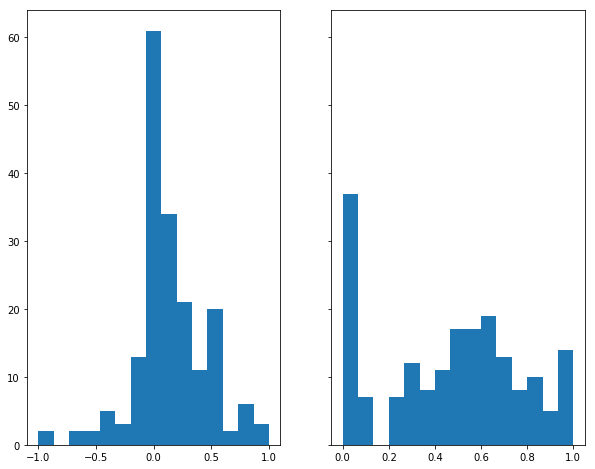

In [13]:
# PLOT RESULTS (TextBlob) - HISTOGRAMS
x = df_comments['Polarity'].values
y = df_comments['Subjectivity'].values

# plt.rcParams['figure.figsize']=[12,10]
# plt.subplot(1,2,1)
# plt

f, ax = plt.subplots(1,2, figsize=(10,8), sharey=True)
ax[0].hist(x, bins=15)
ax[1].hist(y, bins=15)
plt.show();

## IMPROVE SUBPLOTS

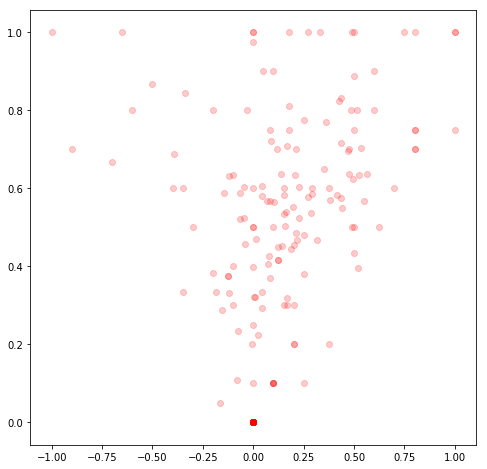

In [14]:
# PLOT RESULTS (TextBlob) - SCATTERPLOT, subjectivity vs. polarity
plt.figure(figsize=(8,8))
plt.scatter(x, y, marker='o', color = 'red', alpha=0.2)
plt.show();

# 2. Set up, run webscraping pipeline

Scrape, make csvs, and run NLP for most popular comics

### 2.1 Scrape the most popular comics

In [15]:
# GET A LIST OF THE MOST POPULAR SERIES
url = "https://readcomiconline.to/ComicList/MostPopular"
driver = webdriver.Opera(executable_path='webdriver/operadriver_mac64/operadriver')

popular_series = get_issues(url, driver)
print(popular_series)

['https://readcomiconline.to/Comic/The-Walking-Dead', 'https://readcomiconline.to/Comic/The-Walking-Dead/Issue-191?id=154788', 'https://readcomiconline.to/Comic/Injustice-2', 'https://readcomiconline.to/Comic/Batman-2016', 'https://readcomiconline.to/Comic/Batman-2016/Issue-71?id=155456', 'https://readcomiconline.to/Comic/The-Amazing-Spider-Man-1963', 'https://readcomiconline.to/Comic/Ultimate-Spider-Man-2000', 'https://readcomiconline.to/Comic/Saga', 'https://readcomiconline.to/Comic/Saga/Issue-54?id=137529', 'https://readcomiconline.to/Comic/The-Flash-2016', 'https://readcomiconline.to/Comic/The-Flash-2016/Issue-70?id=155185', 'https://readcomiconline.to/Comic/Invincible', 'https://readcomiconline.to/Comic/Injustice-Gods-Among-Us-Year-Five', 'https://readcomiconline.to/Comic/Injustice-Gods-Among-Us-I', 'https://readcomiconline.to/Comic/Darth-Vader-2017', 'https://readcomiconline.to/Comic/Darth-Vader-2017/Issue-25?id=146470', 'https://readcomiconline.to/Comic/Detective-Comics-2016', '

In [44]:
# LOAD A CSV FILE TO A DF (IF NEEDED)
csv_file_path = "comic_comments/comic_comments.csv"
loaded_df = pd.read_csv(csv_file_path, index_col='Unnamed: 0', encoding = "ISO-8859-1")
len(loaded_df)

5826

In [32]:
# SCRAPE ALL ISSUES FOR EVERY SERIES IN popular_series - takes in a loaded_df
driver = webdriver.Opera(executable_path='webdriver/operadriver_mac64/operadriver')
df = harvest(popular_series, df=loaded_df)

df loaded. df length: 3718
Attempting to scrape https://readcomiconline.to/Comic/The-Walking-Dead
df loaded. df length: 3718
Now scraping: https://readcomiconline.to/Comic/The-Walking-Dead/Issue-89
Now scraping: https://readcomiconline.to/Comic/The-Walking-Dead/Issue-88
Now scraping: https://readcomiconline.to/Comic/The-Walking-Dead/Issue-87
Now scraping: https://readcomiconline.to/Comic/The-Walking-Dead/Issue-86
Now scraping: https://readcomiconline.to/Comic/The-Walking-Dead/Issue-85
Now scraping: https://readcomiconline.to/Comic/The-Walking-Dead/Issue-84
Now scraping: https://readcomiconline.to/Comic/The-Walking-Dead/Issue-83
Now scraping: https://readcomiconline.to/Comic/The-Walking-Dead/Issue-82
Now scraping: https://readcomiconline.to/Comic/The-Walking-Dead/Issue-81
Now scraping: https://readcomiconline.to/Comic/The-Walking-Dead/Issue-80
Now scraping: https://readcomiconline.to/Comic/The-Walking-Dead/Issue-79
Now scraping: https://readcomiconline.to/Comic/The-Walking-Dead/Issue-78

SCRAPING FAILED for https://readcomiconline.to/Comic/The-Walking-Dead/Issue-23
Now scraping: https://readcomiconline.to/Comic/The-Walking-Dead/Issue-22
SCRAPING FAILED for https://readcomiconline.to/Comic/The-Walking-Dead/Issue-22
Now scraping: https://readcomiconline.to/Comic/The-Walking-Dead/Issue-21
SCRAPING FAILED for https://readcomiconline.to/Comic/The-Walking-Dead/Issue-21
Now scraping: https://readcomiconline.to/Comic/The-Walking-Dead/Issue-20
SCRAPING FAILED for https://readcomiconline.to/Comic/The-Walking-Dead/Issue-20
Now scraping: https://readcomiconline.to/Comic/The-Walking-Dead/Issue-19
SCRAPING FAILED for https://readcomiconline.to/Comic/The-Walking-Dead/Issue-19
Now scraping: https://readcomiconline.to/Comic/The-Walking-Dead/Issue-18
SCRAPING FAILED for https://readcomiconline.to/Comic/The-Walking-Dead/Issue-18
Now scraping: https://readcomiconline.to/Comic/The-Walking-Dead/Issue-17
SCRAPING FAILED for https://readcomiconline.to/Comic/The-Walking-Dead/Issue-17
Now scrap

SCRAPING FAILED for https://readcomiconline.to/Comic/The-Walking-Dead/Issue-41
Now scraping: https://readcomiconline.to/Comic/The-Walking-Dead/Issue-40
SCRAPING FAILED for https://readcomiconline.to/Comic/The-Walking-Dead/Issue-40
Now scraping: https://readcomiconline.to/Comic/The-Walking-Dead/Issue-39
SCRAPING FAILED for https://readcomiconline.to/Comic/The-Walking-Dead/Issue-39
Now scraping: https://readcomiconline.to/Comic/The-Walking-Dead/Issue-38
SCRAPING FAILED for https://readcomiconline.to/Comic/The-Walking-Dead/Issue-38
Now scraping: https://readcomiconline.to/Comic/The-Walking-Dead/Issue-37
SCRAPING FAILED for https://readcomiconline.to/Comic/The-Walking-Dead/Issue-37
Now scraping: https://readcomiconline.to/Comic/The-Walking-Dead/Issue-36
SCRAPING FAILED for https://readcomiconline.to/Comic/The-Walking-Dead/Issue-36
Now scraping: https://readcomiconline.to/Comic/The-Walking-Dead/Issue-35
SCRAPING FAILED for https://readcomiconline.to/Comic/The-Walking-Dead/Issue-35
Now scrap

NoSuchElementException: Message: no such element: Unable to locate element: {"method":"class name","selector":"listing"}
  (Session info: chrome with embedded Chromium 71.0.3578.98)
  (Driver info: OperaDriver=2.42.3135 (O58),platform=Mac OS X 10.14.4 x86_64)


In [ ]:
df_comments = sentiment_analysis()

# 2. Comic Reviews EDA

## 2.1 Most common review words

USE PREVIOUS NLP SpaCy notebook TO DETERMINE MOST COMMON WORDS

GENERATE A TF-IDF OR WORD COUNT DF

VISUALIZE BY USING WORDCLOUD

https://www.youtube.com/watch?v=VraAbgAoYSk

In [18]:
temp = pd.read_csv('comic_comments/batman_2016_comments.csv')

In [ ]:
# PLOT SENTIMENTS